## Universidad de Costa Rica
### Escuela de Ingeniería Eléctrica
#### IE0405 - Modelos Probabilísticos de Señales y Sistemas

Segundo semestre del 2020

---

* Estudiante: **Jose Miguel Pizarro Viales**
* Carné: **B86079**
* Grupo: **1**

---
# `P4` - *Modulación digital IQ*

### 4.1. - Modulación QPSK

* (50%) Realice una simulación del sistema de comunicaciones como en la sección 3.2., pero utilizando una modulación QPSK en lugar de una modulación BPSK. Deben mostrarse las imágenes enviadas y recuperadas y las formas de onda.


In [1]:
from PIL import Image
import numpy as np

def fuente_info(imagen):
    '''Una función que simula una fuente de
    información al importar una imagen y 
    retornar un vector de NumPy con las 
    dimensiones de la imagen, incluidos los
    canales RGB: alto x largo x 3 canales

    :param imagen: Una imagen en formato JPG
    :return: un vector de pixeles
    '''
    img = Image.open(imagen)
    
    return np.array(img)

In [2]:
import numpy as np

def rgb_a_bit(imagen):
    '''Convierte los pixeles de base 
    decimal (de 0 a 255) a binaria 
    (de 00000000 a 11111111).

    :param imagen: array de una imagen 
    :return: Un vector de (1 x k) bits 'int'
    '''
    # Obtener las dimensiones de la imagen
    x, y, z = imagen.shape
    
    # Número total de pixeles
    n_pixeles = x * y * z

    # Convertir la imagen a un vector unidimensional de n_pixeles
    pixeles = np.reshape(imagen, n_pixeles)

    # Convertir los canales a base 2
    bits = [format(pixel,'08b') for pixel in pixeles]
    bits_Rx = np.array(list(''.join(bits)))
    
    return bits_Rx.astype(int)

In [3]:
import numpy as np

def modulador(bits, fc, mpp):
    '''Un método que simula el esquema de 
    modulación digital QPSK.

    :param bits: Vector unidimensional de bits
    :param fc: Frecuencia de la portadora en Hz
    :param mpp: Cantidad de muestras por periodo de onda portadora
    :return: Un vector con la señal modulada
    :return: Un valor con la potencia promedio [W]
    :return: La onda portadora de fase I c(t)_I
    :return: La onda portadora de fase Q c(t)_Q
    :return: La onda cuadrada moduladora de fase I (información)
    :return: La onda cuadrada moduladora de fase Q (información)
    '''
        
    # 1. Parámetros de la 'señal' de información (bits)
    
    bits_Q = [] #Bits con fase Q
    bits_I = [] #bits con fase I
    
    #Se dividen los bits de 2 en 2
    for i, bit in enumerate(bits):
        if i%2 == 0:
            bits_I.append(bit)
        else:
            bits_Q.append(bit)

    bits_Q = np.array(bits_Q) 
    bits_I = np.array(bits_I)
    
    #Numero de bits por cada fase
    N_Q = len(bits_Q)
    N_I = len(bits_I)

    # 2. Construyendo un periodo de las señales portadoras c(t)_I y c(t)_Q
    Tc = 1 / fc  # periodo [s]
    t_periodo = np.linspace(0, Tc, mpp)
    #NUevas señales portadoras
    portadora_Q = np.sin(2*np.pi*fc*t_periodo)
    portadora_I = np.cos(2*np.pi*fc*t_periodo)  

    # 3. Inicializar las señales moduladas s(t)_I y s(t)_Q
    t_simulacion_Q = np.linspace(0, N_Q*Tc, N_Q*mpp)
    t_simulacion_I = np.linspace(0, N_I*Tc, N_I*mpp)
    senal_Tx_I = np.zeros(t_simulacion_I.shape)
    senal_Tx_Q = np.zeros(t_simulacion_Q.shape)
    moduladora_I = np.zeros(t_simulacion_I.shape)  
    moduladora_Q = np.zeros(t_simulacion_Q.shape)

    # 4. Asignar las formas de onda según los bits (QPSK)
    
    #Bits de fase Q
    for i, bit in enumerate(bits_Q):
        if bit == 1:
            senal_Tx_Q[i*mpp : (i+1)*mpp] = portadora_Q
            moduladora_Q[i*mpp : (i+1)*mpp] = 1
        else:
            senal_Tx_Q[i*mpp : (i+1)*mpp] = portadora_Q * -1
            moduladora_Q[i*mpp : (i+1)*mpp] = 0
    
    #Bits de fase I
    for i, bit in enumerate(bits_I):
        if bit == 1:
            senal_Tx_I[i*mpp : (i+1)*mpp] = portadora_I
            moduladora_I[i*mpp : (i+1)*mpp] = 1
        else:
            senal_Tx_I[i*mpp : (i+1)*mpp] = portadora_I * -1
            moduladora_I[i*mpp : (i+1)*mpp] = 0
  
    # Nueva señal modulada
    senal_Tx = senal_Tx_I + senal_Tx_Q
    
    
    
    
    # 5. Calcular la potencia promedio de la señal modulada
    Pm_Q = (1 / (N_Q*Tc)) * np.trapz(pow(senal_Tx_Q, 2), t_simulacion_Q)
    Pm_I = (1 / (N_I*Tc)) * np.trapz(pow(senal_Tx_I, 2), t_simulacion_I)
    
    Pm = Pm_I + Pm_Q
        
    return senal_Tx, Pm, portadora_Q, portadora_I, moduladora_Q, moduladora_I 

In [4]:
import numpy as np

def canal_ruidoso(senal_Tx, Pm, SNR):
    '''Un bloque que simula un medio de trans-
    misión no ideal (ruidoso) empleando ruido
    AWGN. Pide por parámetro un vector con la
    señal provieniente de un modulador y un
    valor en decibelios para la relación señal
    a ruido.

    :param senal_Tx: El vector del modulador
    :param Pm: Potencia de la señal modulada
    :param SNR: Relación señal-a-ruido en dB
    :return: La señal modulada al dejar el canal
    '''
    # Potencia del ruido generado por el canal
    Pn = Pm / pow(10, SNR/10)

    # Generando ruido auditivo blanco gaussiano
    ruido = np.random.normal(0, np.sqrt(Pn), senal_Tx.shape)

    # Señal distorsionada por el canal ruidoso
    senal_Rx = senal_Tx + ruido

    return senal_Rx

In [5]:
import numpy as np

def demodulador(senal_Rx, portadora_Q, portadora_I, mpp):
    '''Un método que simula un bloque demodulador
    de señales, bajo un esquema QPSK. El criterio
    de demodulación se basa en decodificación por 
    detección de energía.

    :param senal_Rx: La señal recibida del canal
    :param portadora_Q: La onda portadora de fase Q c(t)_Q
    :param portadora_I: La onda portadora se fase I c(t)_I
    :param mpp: Número de muestras por periodo
    :return: Los bits de la señal demodulada
    :return: La señal demodulada de fase Q
    :return: La señal demodulada de fase I
    '''
    # Cantidad de muestras en senal_Rx
    M = len(senal_Rx)

    # Cantidad de bits en transmisión
    N =  int(M / (mpp))

    # Vector para bits obtenidos por la demodulación
    bits_Rx_Q  = np.zeros(N)
    bits_Rx_I  = np.zeros(N)
    bits_Rx = np.zeros(2*N)

    # Vector para la señal demodulada
    senal_demodulada_Q = np.zeros(M)
    senal_demodulada_I = np.zeros(M)

    # Energía de un período de la portadora
    Es_Q = np.sum(portadora_Q**2)
    Es_I = np.sum(portadora_I**2)

    # Demodulación
    for i in range(N):
        #Demodulación de la fase I
        #Producto de dos funciones
        producto_I = senal_Rx[i*mpp : (i+1)*mpp] * portadora_I
        senal_demodulada_I[i*mpp : (i+1)*mpp] = producto_I
        Ep_I = np.sum(producto_I) 

        if Ep_I > 0:
            bits_Rx_I[i] = 1
        else:
            bits_Rx_I[i] = 0
        
        #Demodulación de la fase Q
        # Producto interno de dos funciones
        producto_Q = senal_Rx[i*mpp : (i+1)*mpp] * portadora_Q
        senal_demodulada_Q[i*mpp : (i+1)*mpp] = producto_Q
        Ep_Q = np.sum(producto_Q) 

        # Criterio de decisión por detección de energía
        if Ep_Q > 0:
            bits_Rx_Q[i] = 1
        else:
            bits_Rx_Q[i] = 0
        
        
    #Recuperación de los bits
    
    #Contadores
    N_I = 0
    N_Q = 0
    
    #Algoritmo de recuperación
    for i in range(0, len(bits_Rx)):
        if i%2 == 0: #Debido a que los bits pares se enviaron con fase I
            bits_Rx[i] = bits_Rx_I[N_I]
            N_I = N_I+1
        else: #Debido a que los bits impares se enviaron con fase Q
            bits_Rx[i] = bits_Rx_Q[N_Q]
            N_Q = N_Q+1
            
            
    return bits_Rx.astype(int), senal_demodulada_Q, senal_demodulada_I 

In [6]:
import numpy as np

def bits_a_rgb(bits_Rx, dimensiones):
    '''Un blque que decodifica el los bits
    recuperados en el proceso de demodulación

    :param: Un vector de bits 1 x k 
    :param dimensiones: Tupla con dimensiones de la img.
    :return: Un array con los pixeles reconstruidos
    '''
    # Cantidad de bits
    N = len(bits_Rx)

    # Se reconstruyen los canales RGB
    bits = np.split(bits_Rx, N / 8)

    # Se decofican los canales:
    canales = [int(''.join(map(str, canal)), 2) for canal in bits]
    pixeles = np.reshape(canales, dimensiones)

    return pixeles.astype(np.uint8)

Duración de la simulación:  6.022553443908691
0 errores, para un BER de 0.0000.


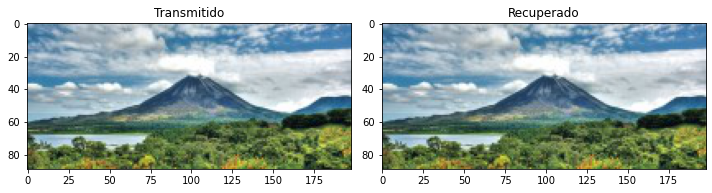

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import time

# Parámetros
fc = 5000  # frecuencia de la portadora
mpp = 20   # muestras por periodo de la portadora
SNR = 5    # relación señal-a-ruido del canal

# Iniciar medición del tiempo de simulación
inicio = time.time()

# 1. Importar y convertir la imagen a trasmitir
imagen_Tx = fuente_info('arenal.jpg')
dimensiones = imagen_Tx.shape

# 2. Codificar los pixeles de la imagen
bits_Tx = rgb_a_bit(imagen_Tx)

# 3. Modular la cadena de bits usando el esquema QPSK
senal_Tx, Pm, portadora_Q, portadora_I, moduladora_Q, moduladora_I = modulador(bits_Tx, fc, mpp)

# 4. Se transmite la señal modulada, por un canal ruidoso
senal_Rx = canal_ruidoso(senal_Tx, Pm, SNR)

# 5. Se desmodula la señal recibida del canal
bits_Rx, senal_demodulada_Q, senal_demodulada_I = demodulador(senal_Rx, portadora_Q, portadora_I, mpp)

# 6. Se visualiza la imagen recibida 
imagen_Rx = bits_a_rgb(bits_Rx, dimensiones)
Fig = plt.figure(figsize=(10,6))

# Cálculo del tiempo de simulación
print('Duración de la simulación: ', time.time() - inicio)

# 7. Calcular número de errores
errores = sum(abs(bits_Tx - bits_Rx))
BER = errores/len(bits_Tx)
print('{} errores, para un BER de {:0.4f}.'.format(errores, BER))

# Mostrar imagen transmitida
ax = Fig.add_subplot(1, 2, 1)
imgplot = plt.imshow(imagen_Tx)
ax.set_title('Transmitido')

# Mostrar imagen recuperada
ax = Fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(imagen_Rx)
ax.set_title('Recuperado')
Fig.tight_layout()

plt.imshow(imagen_Rx)

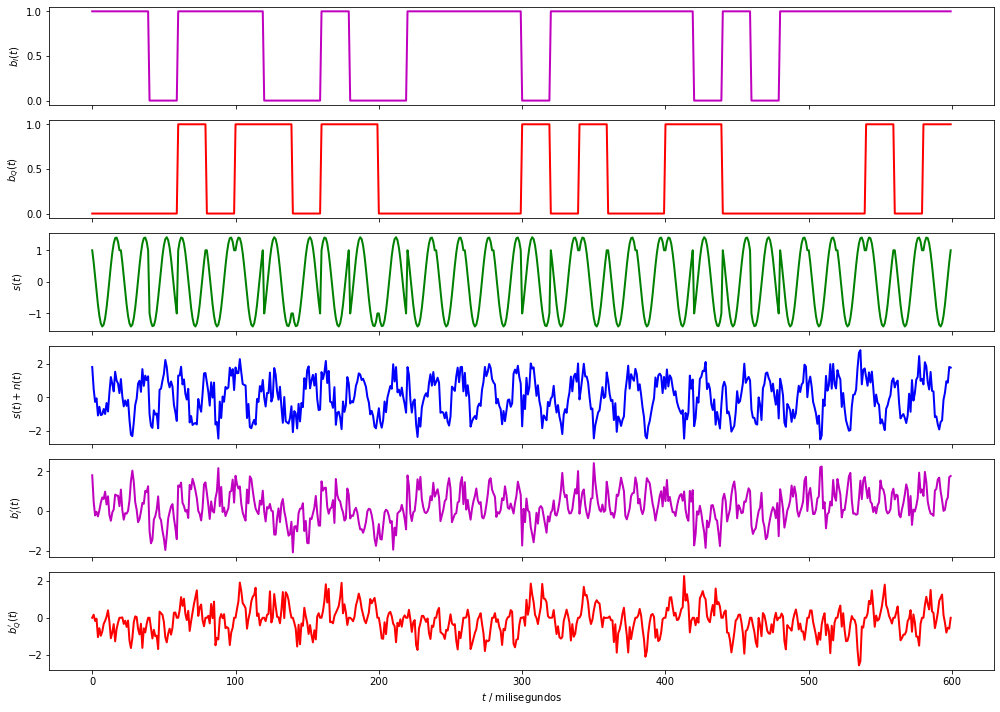

In [8]:
import matplotlib.pyplot as plt

# Visualizar el cambio entre las señales
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(nrows=6, sharex=True, figsize=(14, 10))

# La onda cuadrada moduladora de fase I (bits de entrada)
ax1.plot(moduladora_I[0:600], color='m', lw=2) 
ax1.set_ylabel('$b_I(t)$')

# La onda cuadrada moduladora de fase Q (bits de entrada)
ax2.plot(moduladora_Q[0:600], color='r', lw=2) 
ax2.set_ylabel('$b_Q(t)$')

# La señal modulada por QPSK
ax3.plot(senal_Tx[0:600], color='g', lw=2) 
ax3.set_ylabel('$s(t)$')

# La señal modulada al dejar el canal
ax4.plot(senal_Rx[0:600], color='b', lw=2) 
ax4.set_ylabel('$s(t) + n(t)$')

# La señal demodulada de fase I
ax5.plot(senal_demodulada_I[0:600], color='m', lw=2) 
ax5.set_ylabel('$b^{\prime}_I(t)$')

# La señal demodulada de fase Q
ax6.plot(senal_demodulada_Q[0:600], color='r', lw=2) 
ax6.set_ylabel('$b^{\prime}_Q(t)$')
ax6.set_xlabel('$t$ / milisegundos')
fig.tight_layout()
plt.show()



### 4.2. - Estacionaridad y ergodicidad

* (30%) Realice pruebas de estacionaridad y ergodicidad a la señal modulada `senal_Tx` y obtenga conclusiones sobre estas.


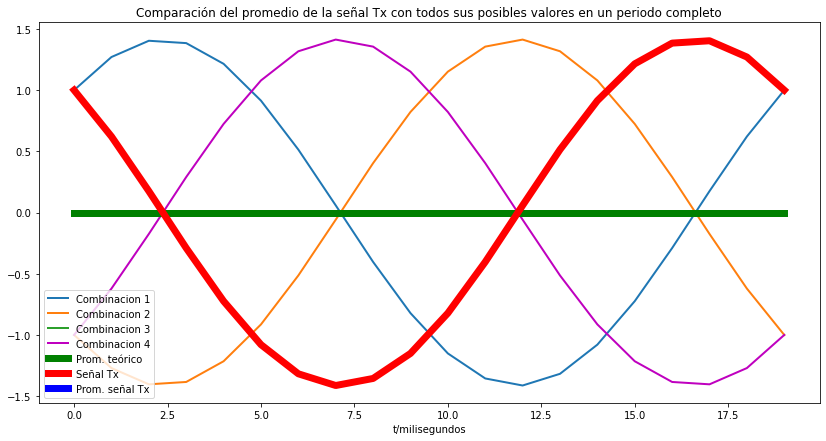

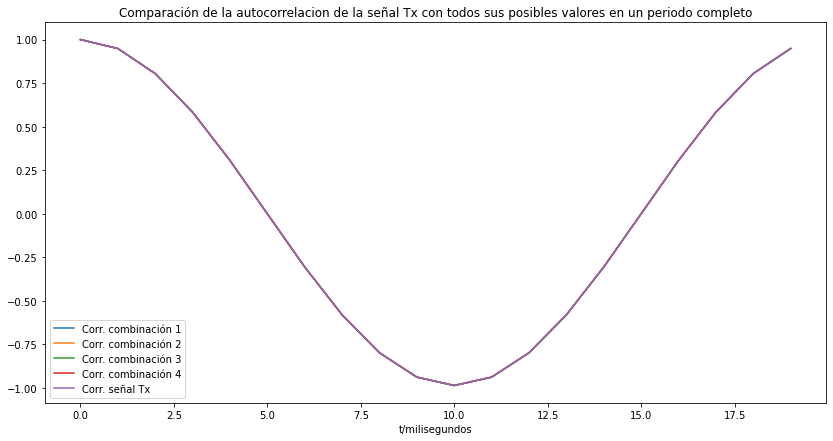

In [9]:
#Posibles combinaciones de las portadoras
comb1 = portadora_I + portadora_Q
comb2 = -portadora_I - portadora_Q
comb3 = portadora_I - portadora_Q
comb4 = -portadora_I + portadora_Q

combinaciones = np.array([comb1, comb2, comb3, comb4])

#Promedio de las combinaciones
Prom_combinaciones = [np.mean(combinaciones[:,i]) for i in range(len(comb1))]

#Gráficos de las combinaciones
plt.figure(figsize=(14, 7))
plt.plot(comb1, lw=2, label='Combinacion 1')
plt.plot(comb2, lw=2, label='Combinacion 2')
plt.plot(comb3, lw=2, label='Combinacion 3')
plt.plot(comb4, lw=2, color='m', label='Combinacion 4')
plt.plot(Prom_combinaciones, color='g', lw=7, label='Prom. teórico')

#Promedio de la señal TX
Prom_Tx = np.mean(senal_Tx)

#Gráficos de la señal TX
plt.plot(senal_Tx[0:len(comb1)], color='r', lw=7, label='Señal Tx')
plt.plot(Prom_Tx, color='b', lw=7, label='Prom. señal Tx')

plt.title('Comparación del promedio de la señal Tx con todos sus posibles valores en un periodo completo')
plt.legend()
plt.xlabel('t/milisegundos')

plt.show()



#Correlación


plt.figure(figsize=(14, 7))

# T valores de desplazamiento tau
desplazamiento = np.arange(len(comb1))

# Inicialización de matriz de valores de correlación para las 4 combinaciones
corr_comb = np.empty((4, len(desplazamiento)))


# Cálculo de correlación en las combinaciones para cada valor de tau
for n in range(4):
	for i, tau in enumerate(desplazamiento):
		corr_comb[n, i] = np.correlate(combinaciones[n,:], np.roll(combinaciones[n,:], tau))/len(comb1)
	plt.plot(corr_comb[n,:], label='Corr. combinación {}'.format(n+1))
    
# Inicialización del vector de valores de correlación para senal_Tx
corr_Tx = np.empty(len(senal_Tx))

# Cálculo de correlación en senal_Tx para cada valor de tau
for i, tau in enumerate(desplazamiento):
	corr_Tx[i] = np.correlate(combinaciones[n,:], np.roll(combinaciones[n,:], tau))/len(comb1)
plt.plot(corr_Tx[0:len(comb1)], label='Corr. señal Tx')


plt.legend()
plt.title('Comparación de la autocorrelacion de la señal Tx con todos sus posibles valores en un periodo completo')
plt.xlabel('t/milisegundos')

plt.show()

### 4.3. - Densidad espectral de potencia

* (20%) Determine y grafique la densidad espectral de potencia para la señal modulada `senal_Tx`.

<ipython-input-10-396a83bccf7a>:4: DeprecationWarning: Using scipy.fft as a function is deprecated and will be removed in SciPy 1.5.0, use scipy.fft.fft instead.
  senal_f = fft(senal_Tx)


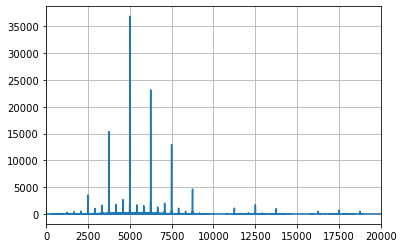

In [10]:
from scipy import fft

#Fourier
senal_f = fft(senal_Tx)

#Muestras por seañal
Nm = len(senal_Tx)

#Numero de simbolos (198 x 89 x 8 x 3) )
Ns = Nm//mpp

#Tiempo del simbolo
Tc = 1/fc

#Periodo de muestreo
Tm = Tc/mpp

#Tiempo de la simulación
T = Ns*Tc

#Espacio de frecuencias
f = np.linspace(0.0, 1.0/(2.0*Tm),Nm//2)

#Grafico
plt.plot(f,2.0/Nm*np.power(np.abs(senal_f[0:Nm//2]),2))
plt.xlim(0,20000)
plt.grid()
plt.show()